In [ ]:
#!/usr/bin/env python
# coding: utf-8

# ==================================================================== #
# author: Yung-Hsin Chen                                               #
# copyright: Copyright 2020, Pneumonia Diagnosis                       #                                                            
# ==================================================================== #

from google.colab import drive
drive.mount('/content/drive')   

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.applications import VGG16
from keras import layers, models
import json
import pandas as pd
os.environ['KMP_DUPLICATE_LIB_OK']='True' # for MAC

### $\underline{Loading\;and\;Storing\;Data}$
##### - Classes: pneumonia, normal
##### - Train (228x228x100), Validation (228x228x16), Test (228x228x5)

In [ ]:
imgX = imgY = 224
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.05,
    height_shift_range=0.15,
    rotation_range=10,
    zoom_range=0.1,
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
path = '/content/drive/My Drive/Colab Notebooks/Pneumonia_ML/chest_x_ray'
train_generator = train_datagen.flow_from_directory(
    path + '/data/train',
    target_size = (imgX, imgY),
    batch_size = 100,#5216
    class_mode = "binary",
    shuffle = True
)
validation_generator = val_datagen.flow_from_directory(
    path +'/data/val',
    target_size = (imgX, imgY),
    batch_size = 16,
    class_mode = "binary",
    shuffle = False
)
test_generator = test_datagen.flow_from_directory(
    path +'/data/test',
    target_size = (imgX, imgY),
    batch_size = 50,#624
    class_mode = "binary",
    shuffle = False
)

Found 5226 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### $\underline{Neural\;Network\;Layers}$
##### - Pretrain: VGG16 (freeze)
##### - Dense (Sigmoid) (smaller model)
##### - Dropout (0.5)
##### - Dense (Sigmoid)

In [ ]:
model = tf.keras.Sequential()
# pretrain
pretrain = tf.keras.applications.vgg16.VGG16(weights = 'imagenet', include_top = False, input_tensor = tf.keras.layers.Input(shape=(imgX, imgY, 3)))
pretrain.trainable = False
model.add(pretrain)
# convnet
'''
print("1")
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding = 'same')) 
print("2")
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
print("3")
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding = 'same')) 
print("4")
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
print("5")
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding = 'same'))
'''
# dropout - prevent overtraining
# lowering the capacity
# print("flatten ok")
model.add(tf.keras.layers.Flatten())
# print("dense1 ok")
model.add(tf.keras.layers.Dense(4, activation='sigmoid'))
# print("dropout1 ok") 
model.add(tf.keras.layers.Dropout(0.5))
# print("dense2 ok")
# model.add(tf.keras.layers.Dense(32, activation='sigmoid')) 
# print("dropout2 ok") 
# model.add(tf.keras.layers.Dropout(0.5))
# print("softmax ok")
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 100356    
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 14,815,049
Trainable params: 100,361
Non-trainable params: 14,714,688
_________________________________________________________________


### $\underline{Training}$

In [ ]:
print("START COMPILING")
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.RMSprop(), metrics=[tf.keras.metrics.binary_crossentropy,'accuracy'])
print("START FITTING")
history = model.fit(train_generator, epochs = 15, validation_data = test_generator)
# history = model.fit(train_generator, validation_data = test_generator, epochs = 15, batch_size = 4)
score = model.evaluate(test_generator, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[2])

START COMPILING
START FITTING
Epoch 1/15
53/53 [==============================] - 154s 3s/step - loss: 0.5009 - binary_crossentropy: 0.5009 - accuracy: 0.8077 - val_loss: 0.4850 - val_binary_crossentropy: 0.4850 - val_accuracy: 0.8638
Epoch 2/15
53/53 [==============================] - 146s 3s/step - loss: 0.4365 - binary_crossentropy: 0.4365 - accuracy: 0.8676 - val_loss: 0.4550 - val_binary_crossentropy: 0.4550 - val_accuracy: 0.8606
Epoch 3/15
53/53 [==============================] - 147s 3s/step - loss: 0.4058 - binary_crossentropy: 0.4058 - accuracy: 0.8879 - val_loss: 0.4672 - val_binary_crossentropy: 0.4672 - val_accuracy: 0.7933
Epoch 4/15
53/53 [==============================] - 144s 3s/step - loss: 0.3753 - binary_crossentropy: 0.3753 - accuracy: 0.8978 - val_loss: 0.4091 - val_binary_crossentropy: 0.4091 - val_accuracy: 0.8958
Epoch 5/15
53/53 [==============================] - 143s 3s/step - loss: 0.3660 - binary_crossentropy: 0.3660 - accuracy: 0.8959 - val_loss: 0.4052 - 

### $\underline{Saving\;History}$

In [ ]:
path_load = '/content/drive/My Drive/Colab Notebooks/Pneumonia_ML/chest_x_ray/model3-2'
with open(path_load + '/accuracy.txt', 'w') as fh_va:
  accuracy_result = [str(i) + '\n' for i in history.history['val_accuracy']]
  fh_va.writelines(accuracy_result)
with open(path_load + '/train_accuracy.txt', 'w') as fh_a:
  trainaccuracy_result = [str(i) + '\n' for i in history.history['accuracy']]
  fh_a.writelines(trainaccuracy_result)
with open(path_load + '/loss.txt', 'w') as fh_vl:
  loss_result = [str(i) + '\n' for i in history.history['val_loss']]
  fh_vl.writelines(loss_result)
with open(path_load + '/train_loss.txt', 'w') as fh_l:
  trainloss_result = [str(i) + '\n' for i in history.history['loss']]
  fh_l.writelines(trainloss_result)

In [ ]:
path_load = '/content/drive/My Drive/Colab Notebooks/Pneumonia_ML/chest_x_ray/model3-2'
fh_va = open(path_load + '/accuracy.txt', 'r')
accuracy = fh_va.readlines()
accuracy = [float(i) for i in accuracy]
fh_a = open(path_load + '/train_accuracy.txt', 'r')
train_accuracy = fh_a.readlines()
train_accuracy = [float(i) for i in train_accuracy]
fh_vl = open(path_load + '/loss.txt', 'r')
loss = fh_vl.readlines()
loss = [float(i) for i in loss]
fh_l = open(path_load + '/train_loss.txt', 'r')
train_loss = fh_l.readlines()
train_loss = [float(i) for i in train_loss]

(0.5, 1.0)

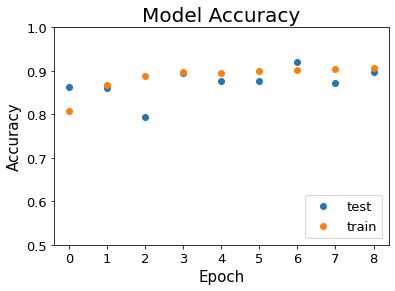

In [ ]:
plt.plot(accuracy[:9], 'o', label = 'test')
plt.plot(train_accuracy[:9], 'o', label = 'train')
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(loc='lower right', fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylim(0.5, 1)

(0.0, 1.0)

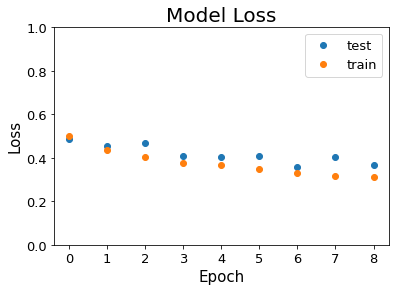

In [ ]:
plt.plot(loss[:9], 'o', label = 'test')
plt.plot(train_loss[:9], 'o', label = 'train')
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(loc='upper right', fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylim(0, 1)